In [88]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import joblib
import pathlib
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.vgg16 import preprocess_input

In [89]:
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_score = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_score

In [90]:
model = load_model("model/VGG-16_lr104.h5", custom_objects={"f1_score": f1_score })
# model = load_model("https://gitlab.com/sdwiulfah/face-anti-spoofing-model/-/blob/main/VGG-16_lr104.h5", custom_objects={"f1_score": f1_score })

In [91]:
img = cv2.cvtColor(cv2.imread("images/ra_live.jpg"), cv2.COLOR_BGR2RGB)

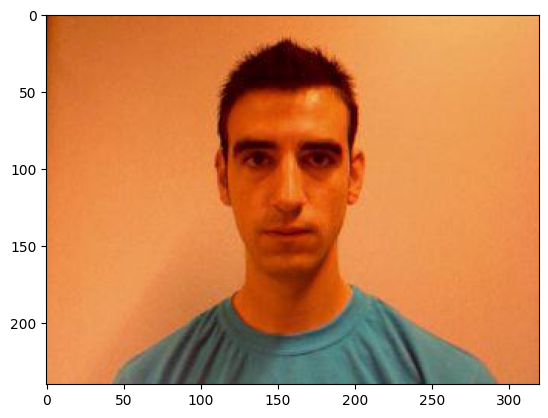

In [92]:
plt.imshow(img)

In [93]:
img.shape

(240, 320, 3)

In [94]:
processed_img = preprocess_input(img)/255
processed_img = cv2.resize(processed_img, (224,224))

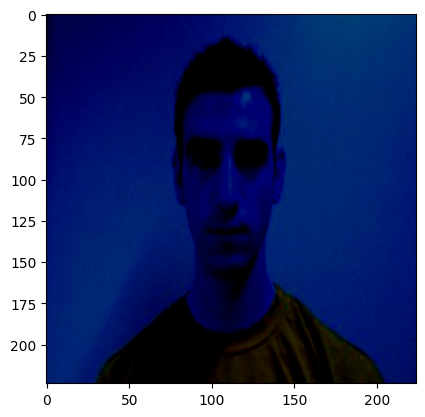

In [95]:
plt.imshow(processed_img)

In [96]:
processed_img = np.expand_dims(processed_img, 0)

In [97]:
prob = model.predict(processed_img)
pred = "spoof" if prob[0][0] > 0.5  else "live"
print(pred)
print(prob[0][0])

1/1 [==============================] - 1s 593ms/step
live
0.0028113867


In [98]:
pred

'live'

# Try .pkl

In [99]:
joblib.dump(model, 'model.pkl')

# still exceed Github

['model.pkl']

## Try TFLite

In [100]:
tf.saved_model.save(model, 'vgg16_for_tflite')

INFO:tensorflow:Assets written to: vgg16_for_tflite\assets


INFO:tensorflow:Assets written to: vgg16_for_tflite\assets


In [101]:
import tensorflow as tf

# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model('vgg16_for_tflite') # path to the SavedModel directory
converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_models_dir = pathlib.Path("vgg16_tflite_model")
tflite_models_dir.mkdir(exist_ok=True, parents=True)

tflite_quant_model = converter.convert()
tflite_model_quant_file = tflite_models_dir/"vgg16_tflite.tflite"
tflite_model_quant_file.write_bytes(tflite_quant_model)

14812608

In [102]:
# try to make prediction

interpreter_quant = tf.lite.Interpreter(model_path=str("vgg16_tflite_model/vgg16_tflite.tflite"))
interpreter_quant.allocate_tensors()

In [103]:
input_index = interpreter_quant.get_input_details()[0]["index"]
output_index = interpreter_quant.get_output_details()[0]["index"]

interpreter_quant.set_tensor(input_index, processed_img)
interpreter_quant.invoke()
probability = interpreter_quant.get_tensor(output_index)
label = "spoof" if prob[0][0] > 0.5  else "live"

In [104]:
predictions

array([[0.00289193]], dtype=float32)